# 모듈 설치

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install -q joblib==1.3
!pip install -q pycaret
!pip install -q catboost
!pip install --upgrade -q xgboost
!pip install bayesian-optimization==1.4.2

# 모듈 불러오기

In [ ]:
# 기본 패키지
import pandas as pd
import numpy as np

# 시각화
import matplotlib.pyplot as plt
import seaborn as sns

# pycaret
from pycaret.regression import *

# 데이터 분리, 그리드 서치
from sklearn.model_selection import train_test_split, GridSearchCV

# 하이퍼 파라미터 최적화
from bayes_opt import BayesianOptimization

# 스케일링
from sklearn.preprocessing import StandardScaler

# 인코딩
from sklearn.preprocessing import LabelEncoder

# 모델링
from xgboost import XGBClassifier
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor

# 보팅
from sklearn.ensemble import VotingRegressor


# 평가
from sklearn.metrics import accuracy_score, classification_report, mean_squared_log_error, make_scorer
from sklearn.datasets import make_regression

# 데이터 준비

## 데이터 획득

In [ ]:
train = pd.read_csv('/content/drive/MyDrive/테크잇 /9. 파이널 프로젝트 - 12/abalon/train.csv')
test = pd.read_csv('/content/drive/MyDrive/테크잇 /9. 파이널 프로젝트 - 12/abalon/test.csv')
submission = pd.read_csv('/content/drive/MyDrive/테크잇 /9. 파이널 프로젝트 - 12/abalon/submission.csv')
origin = pd.read_csv('/content/drive/MyDrive/테크잇 /9. 파이널 프로젝트 - 12/abalon/Original.csv')

In [ ]:
for i in [train,test,submission, origin] :
  display(i.head(2))

,id,Sex,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight,Rings
0,0,F,0.55,0.43,0.150,0.7715,0.3285,0.1465,0.24,11
1,1,F,0.63,0.49,0.145,1.1300,0.4580,0.2765,0.32,11


,id,Sex,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight
0,90615,M,0.645,0.475,0.155,1.238,0.6185,0.3125,0.3005
1,90616,M,0.580,0.460,0.160,0.983,0.4785,0.2195,0.2750


,id,Rings
0,90615,10
1,90616,10


,id,Sex,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,Rings
0,0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.15,15
1,1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.07,7


## 데이터 전처리

### id 변수 제거

In [ ]:
# 제거할 변수 이름 'id'
columns_to_drop = ['id']
train.drop(columns=columns_to_drop, inplace=True)
test.drop(columns=columns_to_drop, inplace=True)
origin.drop(columns=columns_to_drop, inplace=True)

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90615 entries, 0 to 90614
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Sex             90615 non-null  object 
 1   Length          90615 non-null  float64
 2   Diameter        90615 non-null  float64
 3   Height          90615 non-null  float64
 4   Whole weight    90615 non-null  float64
 5   Whole weight.1  90615 non-null  float64
 6   Whole weight.2  90615 non-null  float64
 7   Shell weight    90615 non-null  float64
 8   Rings           90615 non-null  int64  
dtypes: float64(7), int64(1), object(1)
memory usage: 6.2+ MB


### 이름 변경

In [ ]:
# 이름 변경 (Shucked weight:껍질 벗긴 무게, Viscera weight: 내장 무게)
train.rename(columns={'Whole weight.1': 'Shucked_weight'}, inplace=True)
train.rename(columns={'Whole weight.2': 'Viscera_weight'}, inplace=True)
train.rename(columns={'Whole weight': 'Whole_weight'}, inplace=True)
train.rename(columns={'Shell weight': 'Shell_weight'}, inplace=True)

test.rename(columns={'Whole weight.1': 'Shucked_weight'}, inplace=True)
test.rename(columns={'Whole weight.2': 'Viscera_weight'}, inplace=True)
test.rename(columns={'Whole weight': 'Whole_weight'}, inplace=True)
test.rename(columns={'Shell weight': 'Shell_weight'}, inplace=True)

In [ ]:
for i in [train,test,submission, origin] :
  display(i.head(2))

,Sex,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,Rings
0,F,0.55,0.43,0.150,0.7715,0.3285,0.1465,0.24,11
1,F,0.63,0.49,0.145,1.1300,0.4580,0.2765,0.32,11


,Sex,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight
0,M,0.645,0.475,0.155,1.238,0.6185,0.3125,0.3005
1,M,0.580,0.460,0.160,0.983,0.4785,0.2195,0.2750


,id,Rings
0,90615,10
1,90616,10


,Sex,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,Rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.15,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.07,7


### train+origin

In [ ]:
# 훈련 데이터 양을 늘리기 위해 원본 데이터와 concat
train = pd.concat([train,origin])

In [ ]:
display(train.head()), train.shape

,Sex,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,Rings
0,F,0.550,0.430,0.150,0.7715,0.3285,0.1465,0.2400,11
1,F,0.630,0.490,0.145,1.1300,0.4580,0.2765,0.3200,11
2,I,0.160,0.110,0.025,0.0210,0.0055,0.0030,0.0050,6
3,M,0.595,0.475,0.150,0.9145,0.3755,0.2055,0.2500,10
4,I,0.555,0.425,0.130,0.7820,0.3695,0.1600,0.1975,9


(None, (94792, 9))

### 중복 제거 - 없음

In [ ]:
# 중복 제거
train.drop_duplicates(inplace=True)
test.drop_duplicates(inplace=True)
train.duplicated().sum(), test.duplicated().sum()

(0, 0)

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 94792 entries, 0 to 4176
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Sex             94792 non-null  object 
 1   Length          94792 non-null  float64
 2   Diameter        94792 non-null  float64
 3   Height          94792 non-null  float64
 4   Whole_weight    94792 non-null  float64
 5   Shucked_weight  94792 non-null  float64
 6   Viscera_weight  94792 non-null  float64
 7   Shell_weight    94792 non-null  float64
 8   Rings           94792 non-null  int64  
dtypes: float64(7), int64(1), object(1)
memory usage: 7.2+ MB


In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60411 entries, 0 to 60410
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Sex             60411 non-null  object 
 1   Length          60411 non-null  float64
 2   Diameter        60411 non-null  float64
 3   Height          60411 non-null  float64
 4   Whole_weight    60411 non-null  float64
 5   Shucked_weight  60411 non-null  float64
 6   Viscera_weight  60411 non-null  float64
 7   Shell_weight    60411 non-null  float64
dtypes: float64(7), object(1)
memory usage: 3.7+ MB


### 파생변수 생성

In [ ]:
# 데이터 복사
train2 = train.copy()
test2 = test.copy()

In [ ]:
# 성체 전복 파생변수 생성
train2['IsAdult'] = 0
train2.loc[train2['Sex'].isin(['M', 'F']), 'IsAdult'] = 1

test2['IsAdult'] = 0
test2.loc[test2['Sex'].isin(['M', 'F']), 'IsAdult'] = 1
display(train2.head(2), test2.head(2))

,Sex,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,Rings,IsAdult
0,F,0.55,0.43,0.150,0.7715,0.3285,0.1465,0.24,11,1
1,F,0.63,0.49,0.145,1.1300,0.4580,0.2765,0.32,11,1


,Sex,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,IsAdult
0,M,0.645,0.475,0.155,1.238,0.6185,0.3125,0.3005,1
1,M,0.580,0.460,0.160,0.983,0.4785,0.2195,0.2750,1


In [ ]:
# 데이터 복사
train3 = train2.copy()
test3 = test2.copy()

# 전체 무게(Whole_weight) = 껍질을 제외한 무게(Shucked Weight) + 껍질의 무게(Shell_weight) 가 아니다
# -> 전체 무게 - 껍질을 제외한 무게 - 껍질의 무게 = 피와 물의 무게

train3['Water'] = (train["Whole_weight"] - train["Shucked_weight"] + train["Shell_weight"])
test3['Water'] = (test["Whole_weight"] - test["Shucked_weight"] + test["Shell_weight"])


# 전복의 부피(Volume) = 길이 * 지름 * 높이 (Length * Diameter * Height)
train3['Volume'] = (train["Length"] * train["Diameter"] * train["Height"])
test3['Volume'] = (test["Length"] * test["Diameter"] * test["Height"])


# 밀도(실수율, 순살의 비율) = 껍질을 제외한 무게/부피
train3['Density'] = (train["Shucked_weight"] / train3["Volume"])
test3['Density'] = (test["Shucked_weight"] / test3["Volume"])

train3.head(2)

rings_column = train3["Rings"]

# Rings 컬럼 train 데이터에서 삭제
train3.drop(columns=["Rings"], inplace=True)

# Rings 컬럼을 맨 뒤로 이동
train3["Rings"] = rings_column

In [ ]:
train3.head()

,Sex,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,IsAdult,Water,Volume,Density,Rings
0,F,0.550,0.430,0.150,0.7715,0.3285,0.1465,0.2400,1,0.6830,0.035475,9.260042,11
1,F,0.630,0.490,0.145,1.1300,0.4580,0.2765,0.3200,1,0.9920,0.044761,10.232007,11
2,I,0.160,0.110,0.025,0.0210,0.0055,0.0030,0.0050,0,0.0205,0.000440,12.500000,6
3,M,0.595,0.475,0.150,0.9145,0.3755,0.2055,0.2500,1,0.7890,0.042394,8.857438,10
4,I,0.555,0.425,0.130,0.7820,0.3695,0.1600,0.1975,0,0.6100,0.030664,12.050059,9


In [ ]:
test3.head(2)

,Sex,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,IsAdult,Water,Volume,Density
0,M,0.645,0.475,0.155,1.238,0.6185,0.3125,0.3005,1,0.9200,0.047488,13.024309
1,M,0.580,0.460,0.160,0.983,0.4785,0.2195,0.2750,1,0.7795,0.042688,11.209239


In [ ]:
zero_count = (train.Height == 0).sum()
print("0의 개수:", zero_count)

0의 개수: 8


### 인코딩

In [ ]:
# 인코딩
encoder = LabelEncoder()
train['Sex'] = encoder.fit_transform(train['Sex'])
test['Sex'] = encoder.fit_transform(test['Sex'])
train.head()

,Sex,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,Rings
0,0,0.550,0.430,0.150,0.7715,0.3285,0.1465,0.2400,11
1,0,0.630,0.490,0.145,1.1300,0.4580,0.2765,0.3200,11
2,1,0.160,0.110,0.025,0.0210,0.0055,0.0030,0.0050,6
3,2,0.595,0.475,0.150,0.9145,0.3755,0.2055,0.2500,10
4,1,0.555,0.425,0.130,0.7820,0.3695,0.1600,0.1975,9


In [ ]:
# 인코딩
encoder = LabelEncoder()
train2['Sex'] = encoder.fit_transform(train2['Sex'])
test2['Sex'] = encoder.fit_transform(test2['Sex'])
display(train2.head(2), test2.head(2))

,Sex,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,Rings,IsAdult
0,0,0.55,0.43,0.150,0.7715,0.3285,0.1465,0.24,11,1
1,0,0.63,0.49,0.145,1.1300,0.4580,0.2765,0.32,11,1


,Sex,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,IsAdult
0,2,0.645,0.475,0.155,1.238,0.6185,0.3125,0.3005,1
1,2,0.580,0.460,0.160,0.983,0.4785,0.2195,0.2750,1


In [ ]:
# 인코딩
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
train3['Sex'] = encoder.fit_transform(train3['Sex'])
test3['Sex'] = encoder.fit_transform(test3['Sex'])
train3.head()

,Sex,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,IsAdult,Water,Volume,Density,Rings
0,0,0.550,0.430,0.150,0.7715,0.3285,0.1465,0.2400,1,0.6830,0.035475,9.260042,11
1,0,0.630,0.490,0.145,1.1300,0.4580,0.2765,0.3200,1,0.9920,0.044761,10.232007,11
2,1,0.160,0.110,0.025,0.0210,0.0055,0.0030,0.0050,0,0.0205,0.000440,12.500000,6
3,2,0.595,0.475,0.150,0.9145,0.3755,0.2055,0.2500,1,0.7890,0.042394,8.857438,10
4,1,0.555,0.425,0.130,0.7820,0.3695,0.1600,0.1975,0,0.6100,0.030664,12.050059,9


### 로그 변환

In [ ]:
# 로그 변환
train["Sex"]=np.log(0.00001+train["Sex"])
train["Length"]=np.log(0.00001+train["Length"])
train["Diameter"]=np.log(0.00001+train["Diameter"])
train["Height"]=np.log(0.00001+train["Height"])
train["Whole_weight"]=np.log(0.00001+train["Whole_weight"])
train["Shucked_weight"]=np.log(0.00001+train["Shucked_weight"])
train["Viscera_weight"]=np.log(0.00001+train["Viscera_weight"])
train["Shell_weight"]=np.log(0.00001+train["Shell_weight"])


test["Sex"]=np.log(0.00001+test["Sex"])
test["Length"]=np.log(0.00001+test["Length"])
test["Diameter"]=np.log(0.00001+test["Diameter"])
test["Height"]=np.log(0.00001+test["Height"])
test["Whole_weight"]=np.log(0.00001+test["Whole_weight"])
test["Shucked_weight"]=np.log(0.00001+test["Shucked_weight"])
test["Viscera_weight"]=np.log(0.00001+test["Viscera_weight"])
test["Shell_weight"]=np.log(0.00001+test["Shell_weight"])

In [ ]:
# 로그 변환
train2["Sex"]=np.log(0.00001+train2["Sex"])
train2["Length"]=np.log(0.00001+train2["Length"])
train2["Diameter"]=np.log(0.00001+train2["Diameter"])
train2["Height"]=np.log(0.00001+train2["Height"])
train2["Whole_weight"]=np.log(0.00001+train2["Whole_weight"])
train2["Shucked_weight"]=np.log(0.00001+train2["Shucked_weight"])
train2["Viscera_weight"]=np.log(0.00001+train2["Viscera_weight"])
train2["Shell_weight"]=np.log(0.00001+train2["Shell_weight"])


test2["Sex"]=np.log(0.00001+test2["Sex"])
test2["Length"]=np.log(0.00001+test2["Length"])
test2["Diameter"]=np.log(0.00001+test2["Diameter"])
test2["Height"]=np.log(0.00001+test2["Height"])
test2["Whole_weight"]=np.log(0.00001+test2["Whole_weight"])
test2["Shucked_weight"]=np.log(0.00001+test2["Shucked_weight"])
test2["Viscera_weight"]=np.log(0.00001+test2["Viscera_weight"])
test2["Shell_weight"]=np.log(0.00001+test2["Shell_weight"])

In [ ]:
# 로그 변환
train3["Sex"]=np.log(0.00001+train3["Sex"])
train3["Length"]=np.log(0.00001+train3["Length"])
train3["Diameter"]=np.log(0.00001+train3["Diameter"])
train3["Height"]=np.log(0.00001+train3["Height"])
train3["Whole_weight"]=np.log(0.00001+train3["Whole_weight"])
train3["Shucked_weight"]=np.log(0.00001+train3["Shucked_weight"])
train3["Viscera_weight"]=np.log(0.00001+train3["Viscera_weight"])
train3["Shell_weight"]=np.log(0.00001+train3["Shell_weight"])


test3["Sex"]=np.log(0.00001+test3["Sex"])
test3["Length"]=np.log(0.00001+test3["Length"])
test3["Diameter"]=np.log(0.00001+test3["Diameter"])
test3["Height"]=np.log(0.00001+test3["Height"])
test3["Whole_weight"]=np.log(0.00001+test3["Whole_weight"])
test3["Shucked_weight"]=np.log(0.00001+test3["Shucked_weight"])
test3["Viscera_weight"]=np.log(0.00001+test3["Viscera_weight"])
test3["Shell_weight"]=np.log(0.00001+test3["Shell_weight"])

## 데이터 분리

In [ ]:
train_final = train
test_final = test

train_final_feature = train_final.loc[:, train_final.columns != 'Rings']
train_final_target = train_final['Rings']

# 데이터 분리
X_train, X_valid, y_train, y_valid = train_test_split(train_final_feature, train_final_target,
                                                     test_size=0.1,
                                                     stratify=train_final_target,
                                                     random_state=42)

X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((85312, 8), (9480, 8), (85312,), (9480,))

In [ ]:
train_final2 = train2
test_final2 = test2

train_final_feature2 = train_final2.loc[:, train_final2.columns != 'Rings']
train_final_target2 = train_final2['Rings']

# 데이터 분리
X_train2, X_valid2, y_train2, y_valid2 = train_test_split(train_final_feature2, train_final_target2,
                                                     test_size=0.1,
                                                     stratify=train_final_target2,
                                                     random_state=42)

X_train2.shape, X_valid2.shape, y_train2.shape, y_valid2.shape

((85312, 9), (9480, 9), (85312,), (9480,))

In [ ]:
train_final3 = train3
test_final3 = test3

train_final_feature3 = train_final3.loc[:, train_final3.columns != 'Rings']
train_final_target3 = train_final3['Rings']

# 데이터 분리
X_train3, X_valid3, y_train3, y_valid3 = train_test_split(train_final_feature3, train_final_target3,
                                                     test_size=0.1,
                                                     stratify=train_final_target3,
                                                     random_state=42)

X_train3.shape, X_valid3.shape, y_train3.shape, y_valid3.shape

((85312, 12), (9480, 12), (85312,), (9480,))

### 스케일링

In [ ]:
# 스케일링
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_val_scaled = scaler.transform(X_valid)

In [ ]:
X = pd.concat([X_train_scaled_df, y_train.reset_index(drop=True)], axis=1)
X.shape

(85312, 9)

In [ ]:
X.isnull().sum()

Sex               0
Length            0
Diameter          0
Height            0
Whole_weight      0
Shucked_weight    0
Viscera_weight    0
Shell_weight      0
Rings             0
dtype: int64

In [ ]:
# 스케일링
scaler = StandardScaler()
X_train_scaled2 = scaler.fit_transform(X_train2)
X_train_scaled_df2 = pd.DataFrame(X_train_scaled2, columns=X_train2.columns)
X_val_scaled2 = scaler.transform(X_valid2)

In [ ]:
X2 = pd.concat([X_train_scaled_df2, y_train2.reset_index(drop=True)], axis=1)
X2.shape

(85312, 9)

In [ ]:
X.isnull().sum()

Sex               0
Length            0
Diameter          0
Height            0
Whole_weight      0
Shucked_weight    0
Viscera_weight    0
Shell_weight      0
Rings             0
dtype: int64

In [ ]:
#height에 0 존재 -> 파생변수 내 무한대값 발생
# infinity 값 nan으로 대체
X_train3.replace([np.inf, -np.inf], np.nan, inplace=True)
X_valid3.replace([np.inf, -np.inf], np.nan, inplace=True)

# NaN 값을 해당 열의 중앙값으로 대체
X_train3.fillna(X_train3.median(), inplace=True)
X_valid3.fillna(X_valid3.median(), inplace=True)

# 스케일링
scaler = StandardScaler()
X_train_scaled3 = scaler.fit_transform(X_train3)
X_train_scaled_df3 = pd.DataFrame(X_train_scaled3, columns=X_train3.columns)
X_val_scaled3 = scaler.transform(X_valid3)

In [ ]:
X3 = pd.concat([X_train_scaled_df3, y_train3.reset_index(drop=True)], axis=1)
X3.shape

(85312, 13)

In [ ]:
X3.isnull().sum()

Sex               0
Length            0
Diameter          0
Height            0
Whole_weight      0
Shucked_weight    0
Viscera_weight    0
Shell_weight      0
IsAdult           0
Water             0
Volume            0
Density           0
Rings             0
dtype: int64

# EDA

## 타겟 데이터 분포

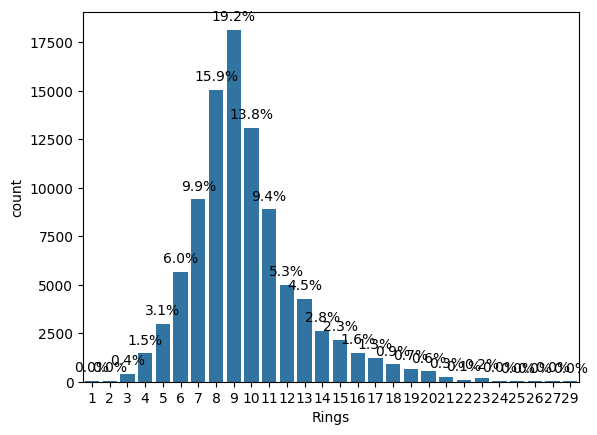

In [ ]:
def custom_countplot(ax, all_data_cnt):
    for bar in ax.patches:
        if bar.get_height() == 0:continue
        rate = bar.get_height() / all_data_cnt*100
        ax.text(
            x = bar.get_x() + bar.get_width()/2
            ,y = bar.get_y() + bar.get_height() + all_data_cnt*0.005
            ,s = f'{rate:1.1f}%'
            ,ha = 'center'
        )
    return ax

chart = custom_countplot(sns.countplot(data=train, x='Rings'), train.shape[0])
chart;

## 피터 데이터 분포 (+파생 변수)

<Axes: xlabel='Rings', ylabel='Count'>

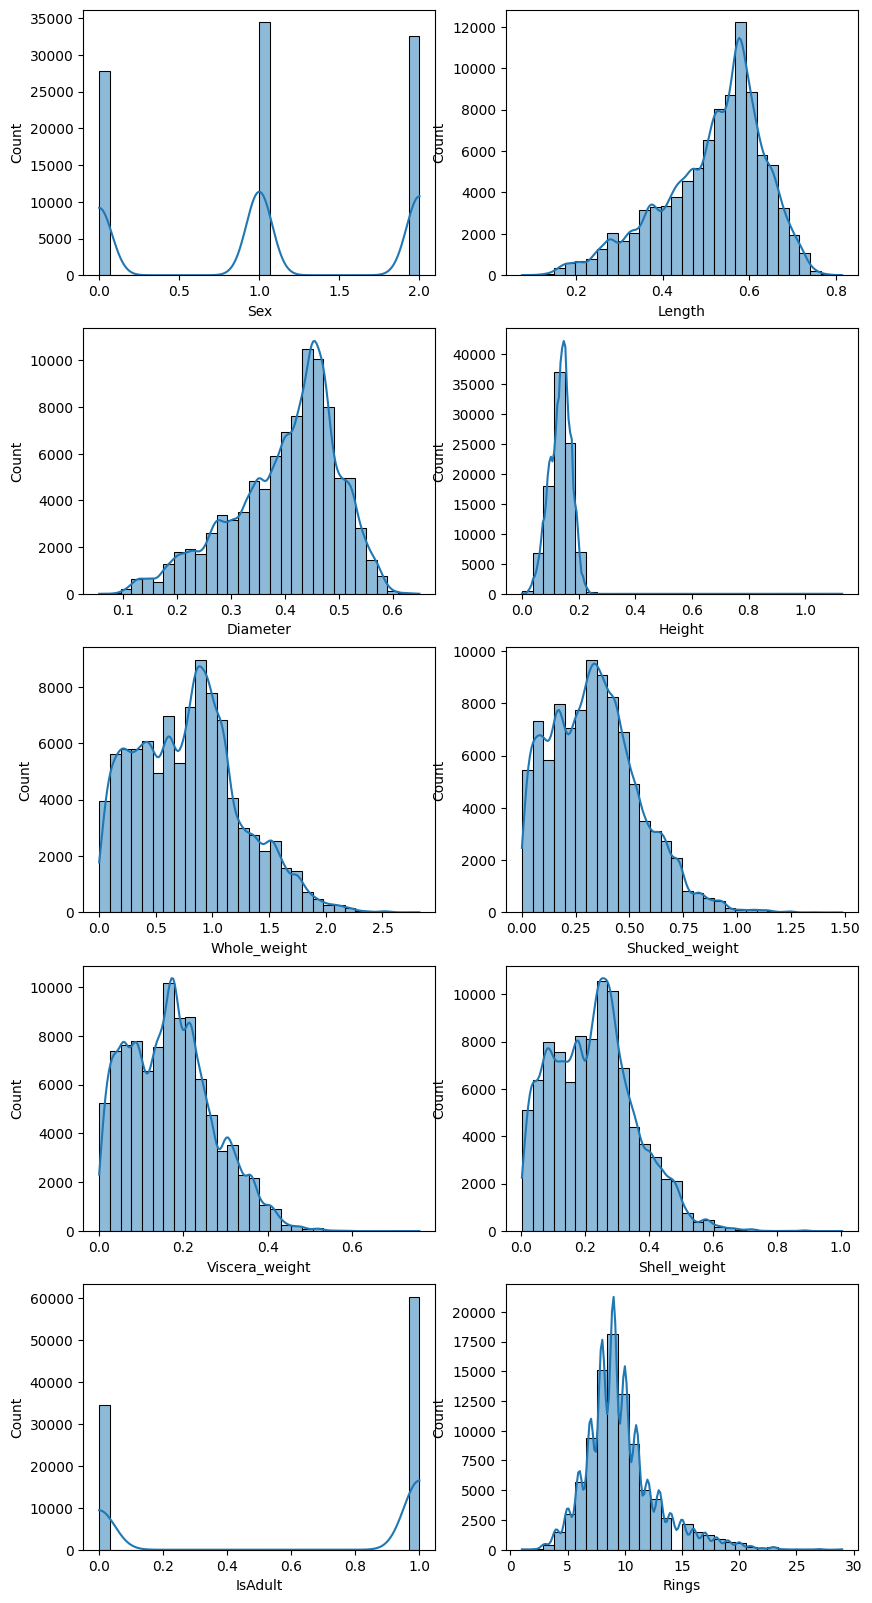

In [ ]:
fig, axes = plt.subplots(5, 2, figsize=(10, 20))

sns.histplot(train['Sex'], bins=30, kde=True, ax=axes[0, 0])

sns.histplot(train['Length'], bins=30, kde=True, ax=axes[0, 1])

sns.histplot(train['Diameter'], bins=30, kde=True, ax=axes[1, 0])

sns.histplot(train['Height'], bins=30, kde=True, ax=axes[1, 1])

sns.histplot(train['Whole_weight'], bins=30, kde=True, ax=axes[2, 0])

sns.histplot(train['Shucked_weight'], bins=30, kde=True, ax=axes[2, 1])

sns.histplot(train['Viscera_weight'], bins=30, kde=True, ax=axes[3, 0])

sns.histplot(train['Shell_weight'], bins=30, kde=True, ax=axes[3, 1])

sns.histplot(train2['IsAdult'], bins=30, kde=True, ax=axes[4, 0])

sns.histplot(train['Rings'], bins=30, kde=True, ax=axes[4, 1])

<Axes: xlabel='Volume', ylabel='Count'>

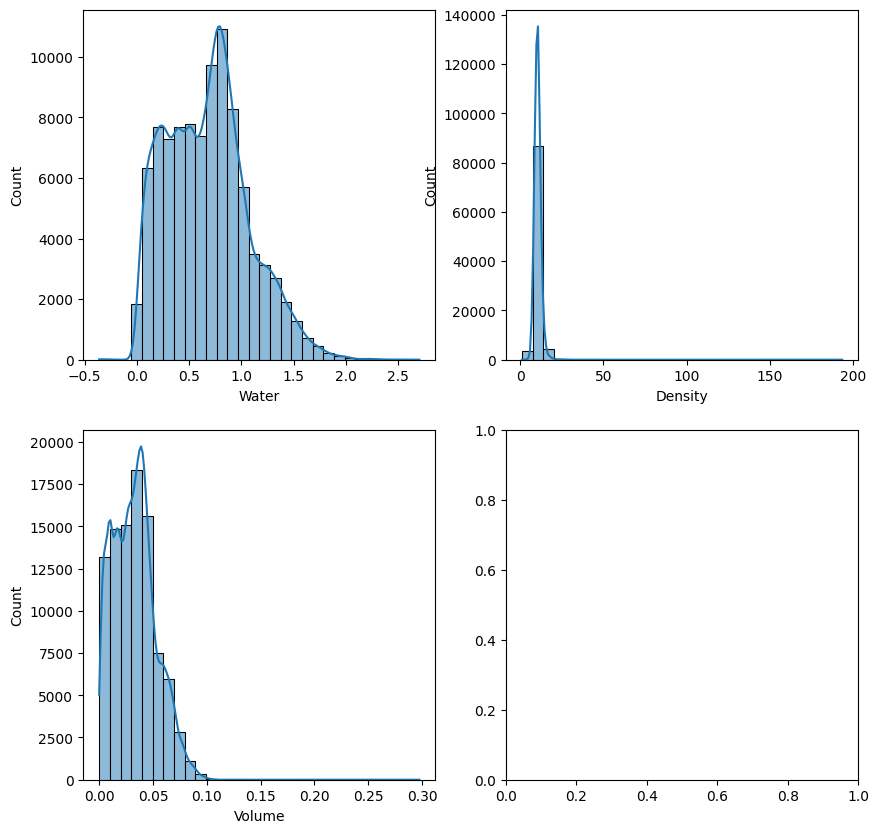

In [ ]:
# 파생변수 Water, Density, Volume의 분포

fig, axes = plt.subplots(2, 2, figsize=(10, 10))

sns.histplot(train3['Water'], bins=30, kde=True, ax=axes[0, 0])

sns.histplot(train3['Density'], bins=30, kde=True, ax=axes[0, 1])

sns.histplot(train3['Volume'], bins=30, kde=True, ax=axes[1, 0])

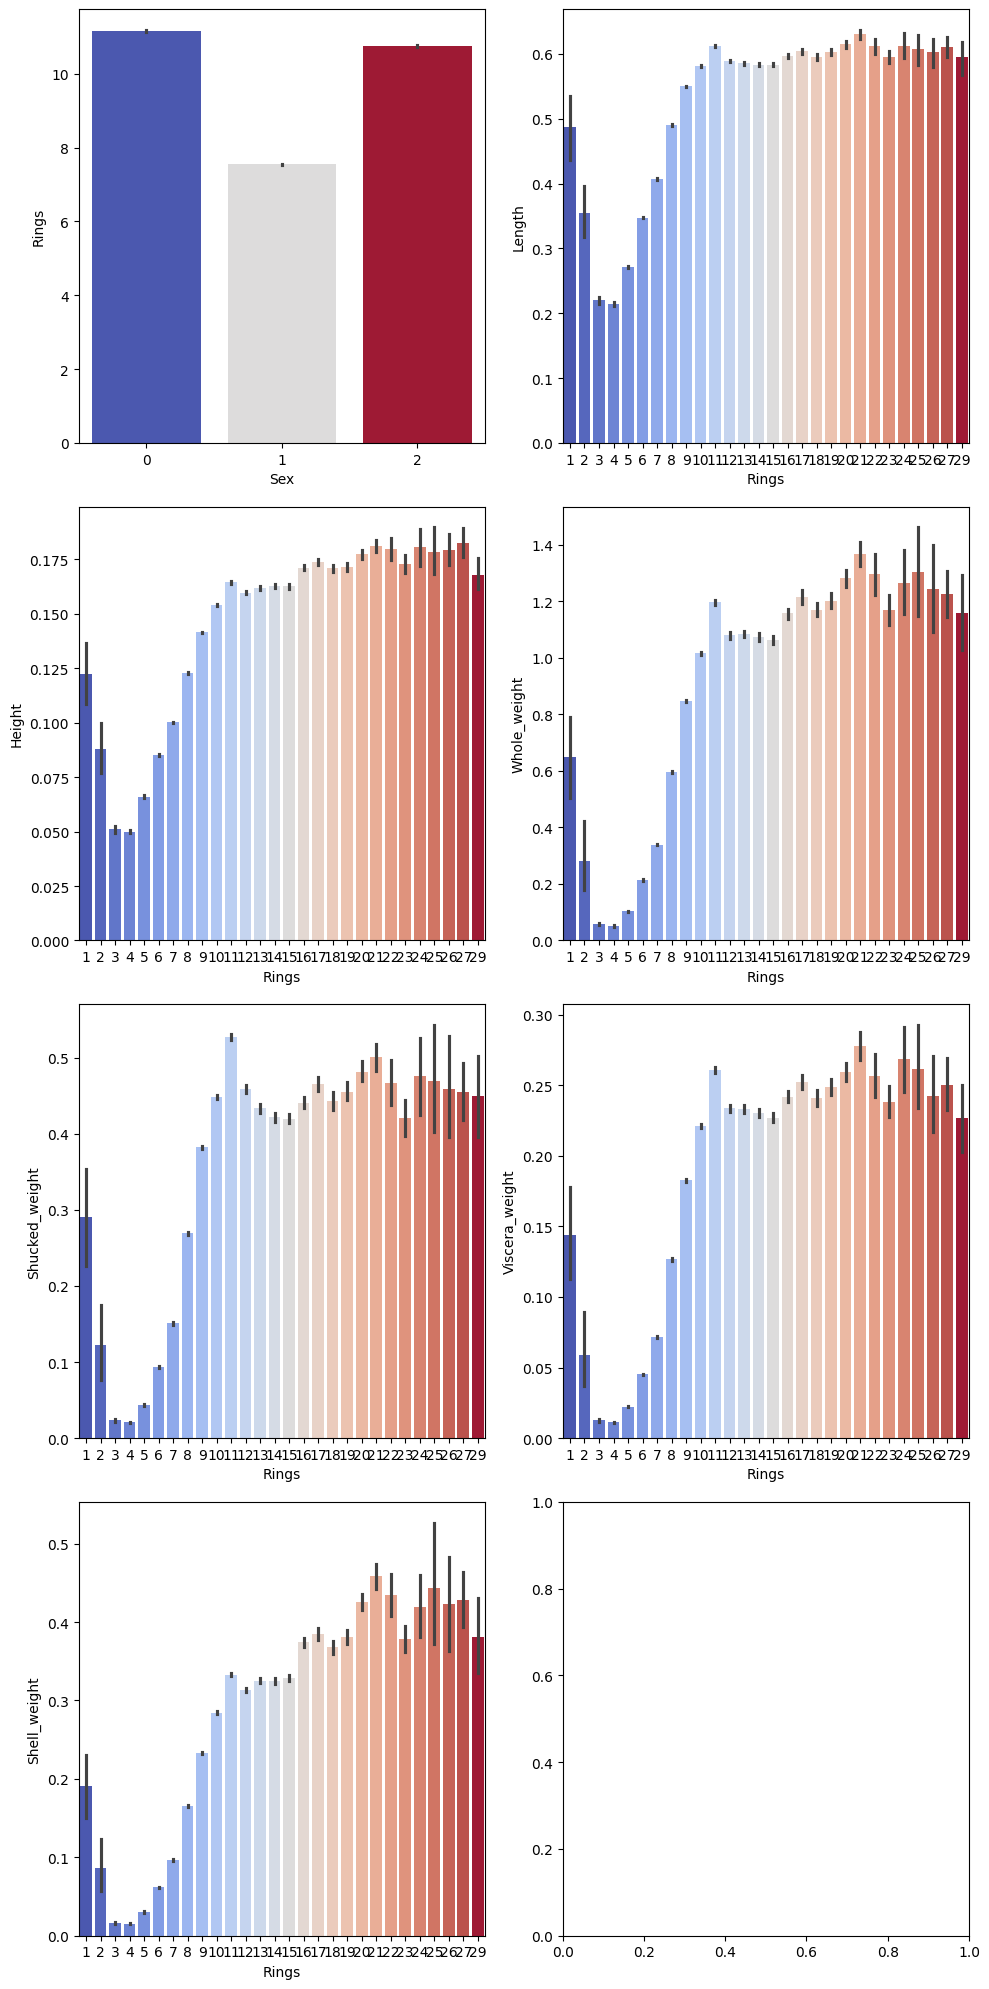

In [ ]:
# 피처 데이터 신뢰구간
fig, axes = plt.subplots(4, 2, figsize=(10, 20))

sns.barplot(x='Sex', y='Rings', data=train, ax=axes[0,0], hue='Sex', palette='coolwarm', legend=False)
sns.barplot(x='Rings', y='Length', data=train, ax=axes[0,1], hue='Rings', palette='coolwarm', legend=False)
sns.barplot(x='Rings', y='Height', data=train, ax=axes[1,0], hue='Rings', palette='coolwarm', legend=False)
sns.barplot(x='Rings', y='Whole_weight', data=train, ax=axes[1,1], hue='Rings', palette='coolwarm', legend=False)
sns.barplot(x='Rings', y='Shucked_weight', data=train, ax=axes[2,0], hue='Rings', palette='coolwarm', legend=False)
sns.barplot(x='Rings', y='Viscera_weight', data=train, ax=axes[2,1], hue='Rings', palette='coolwarm', legend=False)
sns.barplot(x='Rings', y='Shell_weight', data=train, ax=axes[3,0], hue='Rings', palette='coolwarm', legend=False)

plt.tight_layout()
plt.show()

ValueError: cannot reindex on an axis with duplicate labels

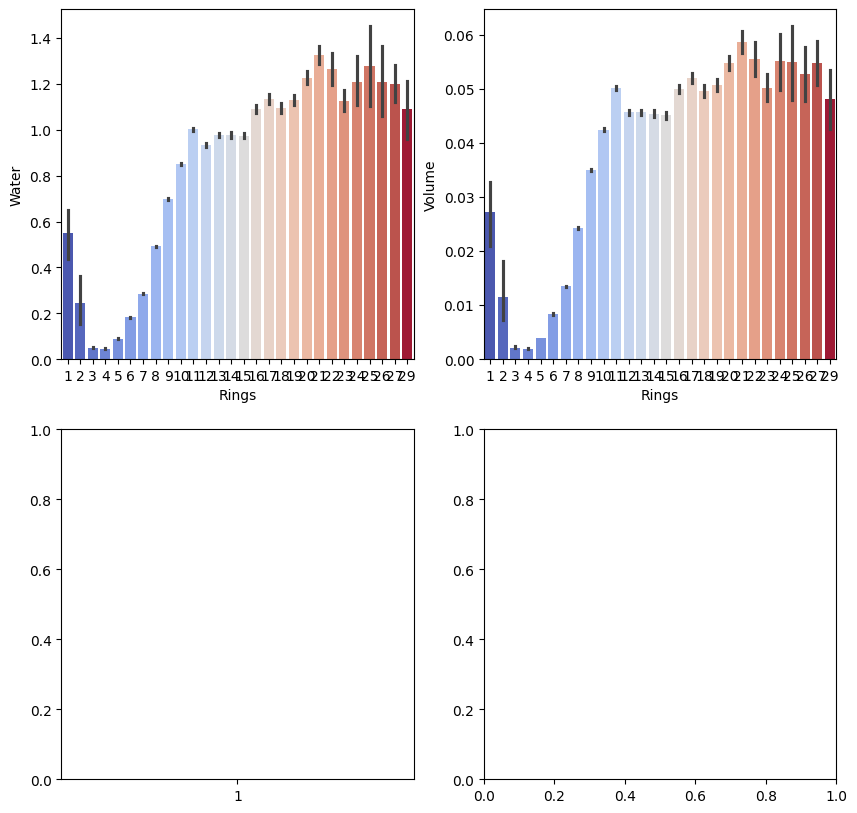

In [ ]:
# 파생변수 water, volume, density(오류) 신뢰구간

fig, axes = plt.subplots(2, 2, figsize=(10, 10))

sns.barplot(x='Rings', y='Water', data=train3, ax=axes[0,0], hue='Rings', palette='coolwarm', legend=False)
sns.barplot(x='Rings', y='Volume', data=train3, ax=axes[0,1], hue='Rings', palette='coolwarm', legend=False)
sns.barplot(x='Rings', y='Density', data=train3, ax=axes[1,0], hue='Rings', palette='coolwarm', legend=False)

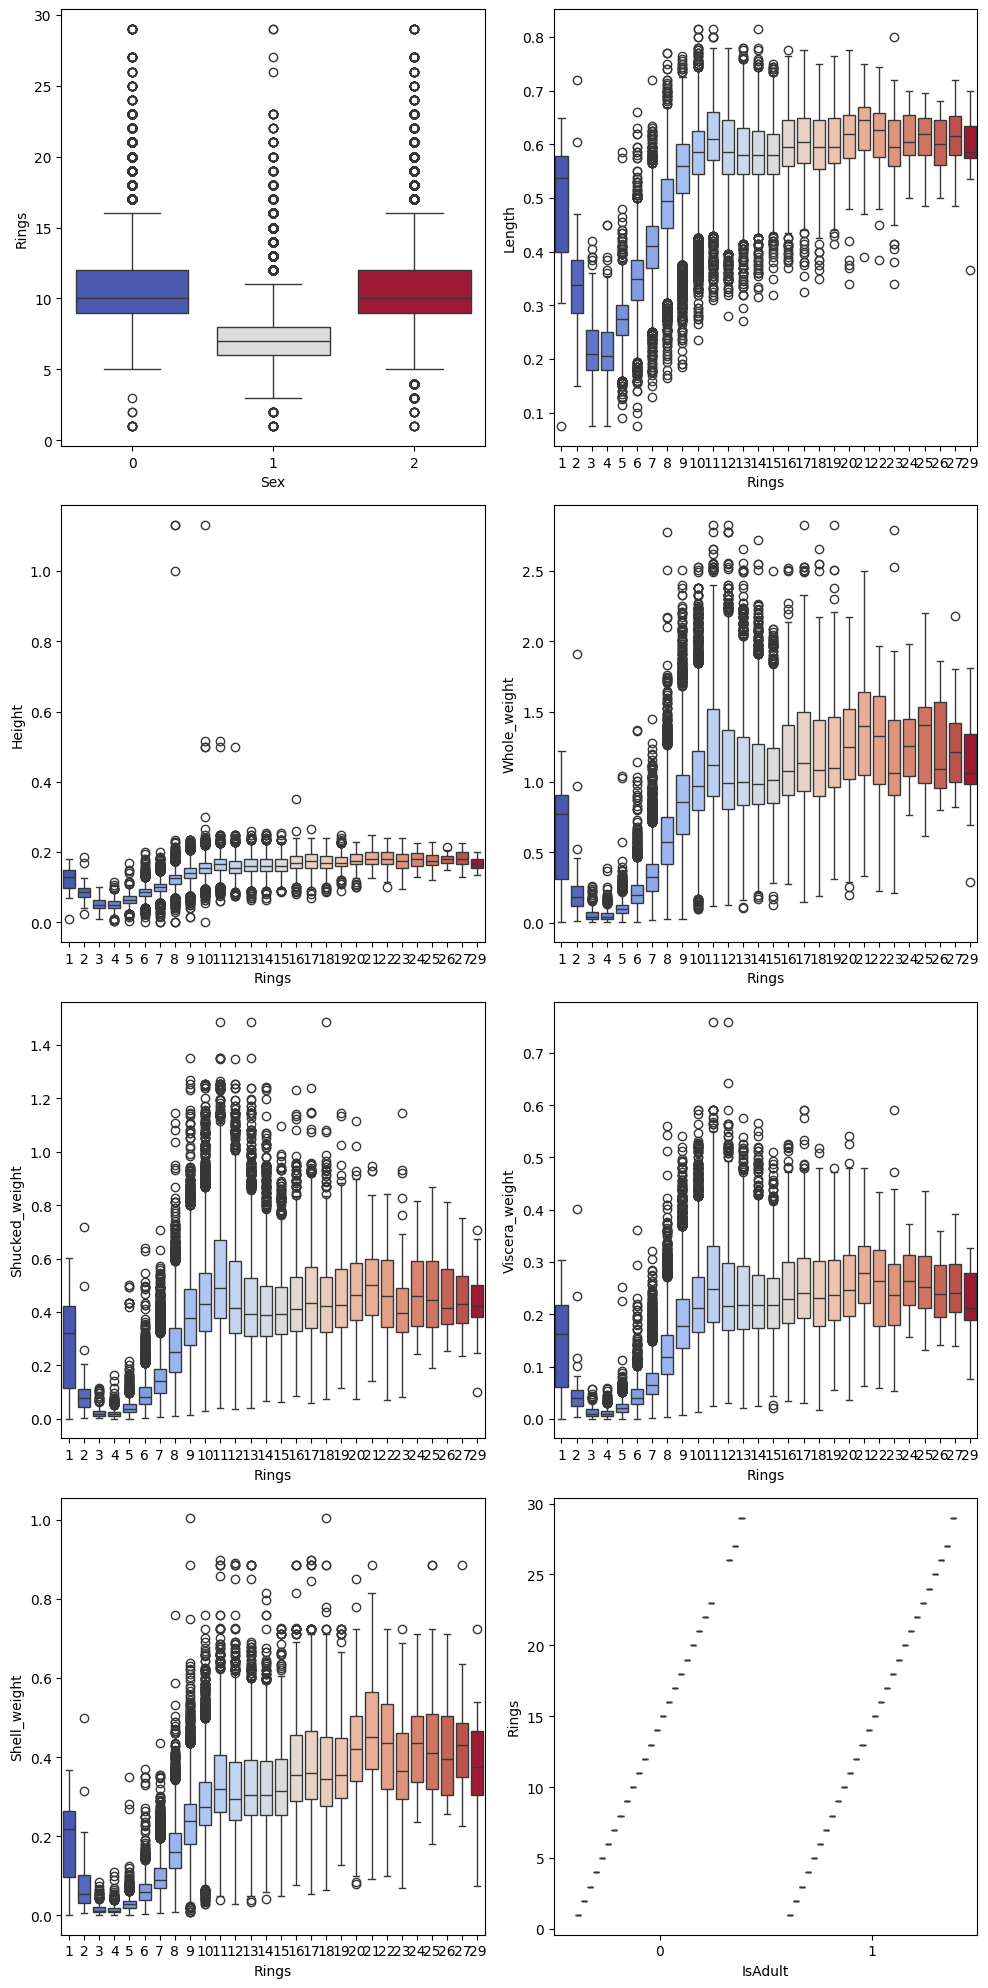

In [ ]:
fig, axes = plt.subplots(4, 2, figsize=(10, 20))

sns.boxplot(x='Sex', y='Rings', data=train, ax=axes[0,0], hue='Sex', palette='coolwarm', legend=False)
sns.boxplot(x='Rings', y='Length', data=train, ax=axes[0,1], hue='Rings', palette='coolwarm', legend=False)
sns.boxplot(x='Rings', y='Height', data=train, ax=axes[1,0], hue='Rings', palette='coolwarm', legend=False)
sns.boxplot(x='Rings', y='Whole_weight', data=train, ax=axes[1,1], hue='Rings', palette='coolwarm', legend=False)
sns.boxplot(x='Rings', y='Shucked_weight', data=train, ax=axes[2,0], hue='Rings', palette='coolwarm', legend=False)
sns.boxplot(x='Rings', y='Viscera_weight', data=train, ax=axes[2,1], hue='Rings', palette='coolwarm', legend=False)
sns.boxplot(x='Rings', y='Shell_weight', data=train, ax=axes[3,0], hue='Rings', palette='coolwarm', legend=False)
sns.boxplot(x='IsAdult', y='Rings', data=train2, ax=axes[3,1], hue='Rings', palette='coolwarm', legend=False)

plt.tight_layout()
plt.show()

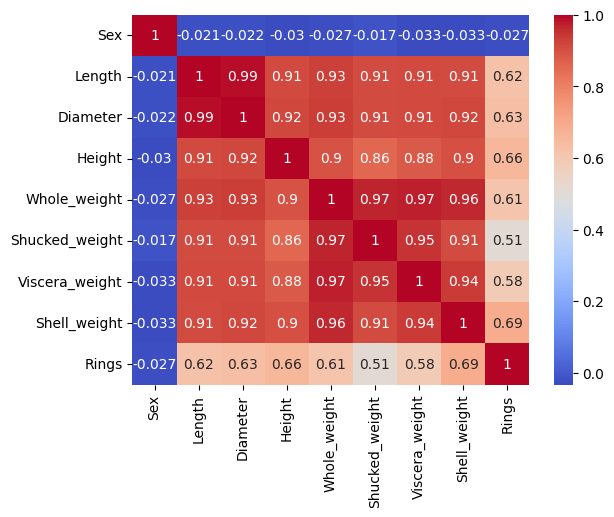

In [ ]:
correlation_matrix = train[['Sex', 'Length', 'Diameter', 'Height', 'Whole_weight', 'Shucked_weight', 'Viscera_weight',
                            'Shell_weight', 'Rings']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()

- sex를 제외한 모든 변수가 rings와 0.5 이상의 강한 양의 상관관계를 보이고 있다.
- sex를 제외한 변수들 간에도 0.9 이상의 강한 양의 상관관계를 보이고 있다.
    - 예측에 특화된 데이터로 추정된다.
- 전복의 나이가 많을 수록 실수율은 떨어진다.

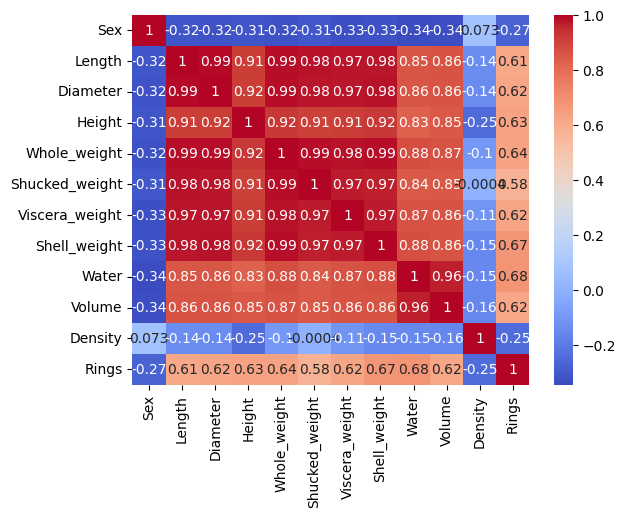

In [ ]:
# 파생변수 water, volume, density 상관관계
correlation_matrix = train3[['Sex', 'Length', 'Diameter', 'Height', 'Whole_weight', 'Shucked_weight', 'Viscera_weight',
                            'Shell_weight', 'Water', 'Volume', 'Density', 'Rings']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()

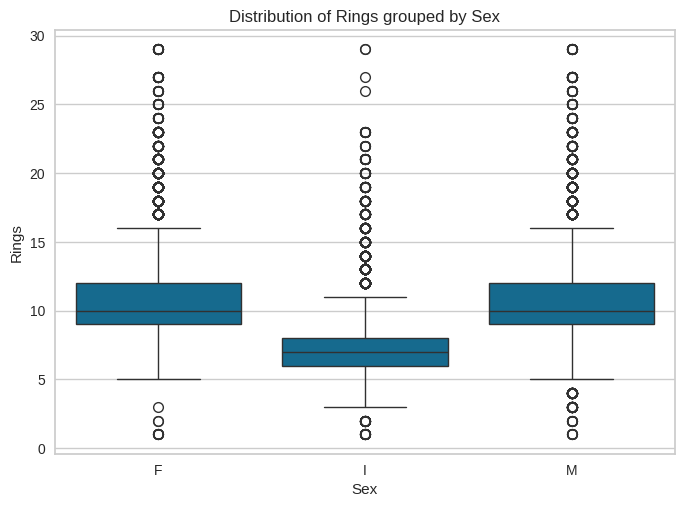

In [ ]:
sns.boxplot(x='Sex', y='Rings', data=train)
plt.title('Distribution of Rings grouped by Sex')
plt.show()

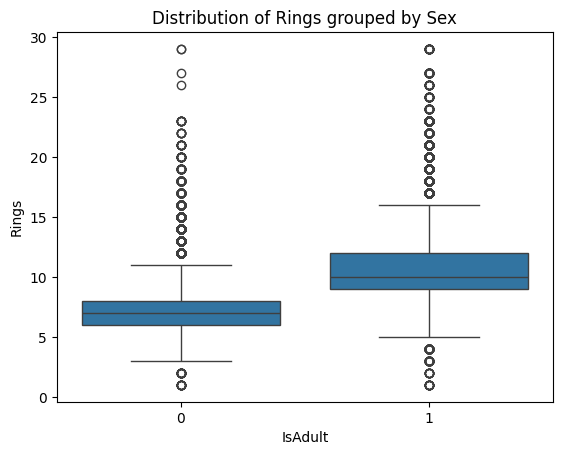

In [ ]:
sns.boxplot(x='IsAdult', y='Rings', data=train2)
plt.title('Distribution of Rings grouped by Sex')
plt.show()

# RMSLE 함수화

In [ ]:
from sklearn.metrics import mean_squared_log_error

def cus_rmsle(y_true, y_pred, transfer = True):
    '''
        - parameters
            - y_true : 실제값
            - y_pred : 예측값
            - transfer : True라면 이미 로그 변환된 값 -> 복원 -> np.exp()
    '''
    # 원래 값의 범위로 복원
    if transfer:
        y_true = np.exp(y_true)
        y_pred = np.exp(y_pred)

    # 로그 변환 후 결측치에 대한 0값에 대한 보정
    # 평가함수 전에 데이터 변환으로 사용되는 함수를 log()로 사용한다는 전제
    log_y_true = np.nan_to_num(np.log1p(y_true))
    log_y_pred = np.nan_to_num(np.log1p(y_pred))

    # RMSLE 처리 진행
    return np.sqrt(np.mean((log_y_true - log_y_pred)**2))

# AutoML

In [ ]:
clf = setup(data=X,
            target='Rings',
            verbose=True,
            train_size=0.9,
            data_split_shuffle=True,
            session_id=42,
            normalize=True,
            )

,Description,Value
0,Session id,42
1,Target,Rings
2,Target type,Regression
3,Original data shape,"(81553, 11)"
4,Transformed data shape,"(81553, 11)"
5,Transformed train set shape,"(73397, 11)"
6,Transformed test set shape,"(8156, 11)"
7,Numeric features,10
8,Preprocess,True
9,Imputation type,simple


In [ ]:
models()

,Name,Reference,Turbo
ID,,,
lr,Linear Regression,sklearn.linear_model._base.LinearRegression,True
lasso,Lasso Regression,sklearn.linear_model._coordinate_descent.Lasso,True
ridge,Ridge Regression,sklearn.linear_model._ridge.Ridge,True
en,Elastic Net,sklearn.linear_model._coordinate_descent.Elast...,True
lar,Least Angle Regression,sklearn.linear_model._least_angle.Lars,True
llar,Lasso Least Angle Regression,sklearn.linear_model._least_angle.LassoLars,True
omp,Orthogonal Matching Pursuit,sklearn.linear_model._omp.OrthogonalMatchingPu...,True
br,Bayesian Ridge,sklearn.linear_model._bayes.BayesianRidge,True
ard,Automatic Relevance Determination,sklearn.linear_model._bayes.ARDRegression,False


In [ ]:
top_5_model = compare_models(fold=5, round=3, n_select=5, errors='ignore')

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
dt,Decision Tree Regressor,0.000,0.000,0.000,1.000,0.000,0.000,0.348
gbr,Gradient Boosting Regressor,0.000,0.000,0.000,1.000,0.000,0.000,9.788
catboost,CatBoost Regressor,0.000,0.000,0.001,1.000,0.001,0.000,13.476
xgboost,Extreme Gradient Boosting,0.000,0.000,0.000,1.000,0.000,0.000,0.370
rf,Random Forest Regressor,0.000,0.000,0.000,1.000,0.000,0.000,10.424
et,Extra Trees Regressor,0.000,0.000,0.003,1.000,0.002,0.000,5.284
lightgbm,Light Gradient Boosting Machine,0.000,0.000,0.007,0.999,0.005,0.000,2.952
knn,K Neighbors Regressor,0.006,0.001,0.023,0.995,0.011,0.002,2.674
ada,AdaBoost Regressor,0.036,0.002,0.046,0.979,0.016,0.017,2.426
br,Bayesian Ridge,0.037,0.004,0.063,0.962,0.025,0.018,0.228


Processing:   0%|          | 0/89 [00:00<?, ?it/s]

# 1st. 기본 전처리 + 로그 변환 + 원본 데이터 + 베이지안 최적화 (cat+lgb+gbr) - 0.14631

## 베이지안 최적화

### catboost

In [ ]:
param_space = {
    'num_leaves': (2, 50),
    'max_depth': (2, 16),
    'learning_rate': (0.01, 1.0),
    'n_estimators': (50, 500),
    'min_child_samples': (2, 100),
    'subsample': (0.1, 1.0)
    }

In [ ]:
# 목적 함수 정의
def my_func(num_leaves, max_depth, learning_rate, n_estimators, min_child_samples, subsample):
    # LGBMRegressor
    model = CatBoostRegressor(num_leaves = int(num_leaves),
                          max_depth = int(max_depth),
                          learning_rate = learning_rate,
                          n_estimators = int(n_estimators),
                          min_child_samples = min_child_samples,
                          subsample = subsample,
                          grow_policy='Lossguide', random_seed=42)
    # 모델 학습
    model.fit(X_train_scaled, np.log1p(y_train), eval_set=(X_val_scaled, np.log(y_valid)), early_stopping_rounds=50, verbose=False)

    # 예측
    y_pred = model.predict(X_val_scaled)

    # RMSLE 계산
    rmsle = np.sqrt(mean_squared_log_error(np.log1p(y_valid), y_pred))

    return -rmsle  # BayesianOptimization은 최대화를 수행하므로 RMSLE을 음수로 반환하여 최적화할 수 있도록 함


optimizer = BayesianOptimization(f=my_func, pbounds=param_space, random_state=42)

In [ ]:
optimizer.maximize(init_points=10, n_iter=100 , acq='ei', xi=0.01)

In [ ]:
optimizer.max

{'target': -0.044954304665286327,
 'params': {'learning_rate': 0.14007279089094354,
  'max_depth': 8.07875486856881,
  'min_child_samples': 19.692214878334603,
  'n_estimators': 245.7575501266606,
  'num_leaves': 32.67437165002963,
  'subsample': 0.955029932115261}}

In [ ]:
# 모델 학습
model = CatBoostRegressor(n_estimators=246,
                          learning_rate=0.14007279089094354,
                          max_depth=8,
                          min_child_samples=20,
                          subsample=0.955029932115261,
                          num_leaves=33,
                          grow_policy='Lossguide',
                          loss_function='RMSE',
                          random_seed=42,
                          verbose=False)

y_train_log = np.log( y_train )
# 학습
model.fit( X_train_scaled, y_train_log )
# 예측
y_pred = model.predict(X_val_scaled)
# 평가
cus_rmsle(np.log(y_valid), y_pred)

0.14901657966857162

### xgboost

In [ ]:
param_space = {
    'learning_rate': (0.01, 0.3),         # 학습률
    'max_depth': (3, 10),                 # 트리의 최대 깊이
    'min_child_weight': (1, 10),          # 각 리프 노드에 필요한 최소 가중치 합
    'gamma': (0, 5),                      # 트리의 리프 노드를 나누기 위한 최소 손실 감소량
    'subsample': (0.5, 1),                # 훈련 데이터 샘플링 비율
    'colsample_bytree': (0.5, 1),         # 각 트리에서의 열 샘플링 비율
    'alpha': (0, 1),                      # L1 정규화 항의 가중치
    'lambda_': (0, 1),                    # L2 정규화 항의 가중치
    'n_estimators': (50, 200)             # 트리의 개수
}

from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from bayes_opt import BayesianOptimization

# 목적 함수 정의
def xgb_objective(learning_rate, max_depth, min_child_weight, gamma, subsample, colsample_bytree, alpha, lambda_, n_estimators):
    # XGBoost
    model = XGBRegressor(learning_rate=learning_rate,
                         max_depth=int(max_depth),
                         min_child_weight=min_child_weight,
                         gamma=gamma,
                         subsample=subsample,
                         colsample_bytree=colsample_bytree,
                         alpha=alpha,
                         lambda_=lambda_,
                         n_estimators=int(n_estimators),
                         random_state=42)

    # 모델 학습
    # y_train을 로그 변환하여 사용
    model.fit(X_train_scaled, np.log1p(y_train))

    # 검증 데이터에 대한 예측
    y_pred = model.predict(X_val_scaled)

    # RMSLE 계산
    rmsle = np.sqrt(mean_squared_log_error(np.log1p(y_valid), y_pred))  # y_valid를 로그 변환하여 사용

    return -rmsle
optimizer = BayesianOptimization(f=xgb_objective, pbounds=param_space, random_state=42)

In [ ]:
optimizer.maximize(init_points=10, n_iter=100 , acq='ei', xi=0.01)

In [ ]:
optimizer.max

{'target': -0.04502217278149122,
 'params': {'alpha': 1.0,
  'colsample_bytree': 0.96221883792814,
  'gamma': 0.0,
  'lambda_': 0.2182683265067961,
  'learning_rate': 0.1810738283210675,
  'max_depth': 5.7544002944125845,
  'min_child_weight': 10.0,
  'n_estimators': 184.66780323454438,
  'subsample': 0.8733552850820253}}

In [ ]:
from xgboost import XGBRegressor

# 모델 학습
model = XGBRegressor(learning_rate=0.1810738283210675,
                     max_depth=6,
                     min_child_weight=10,
                     gamma=0.0,
                     subsample=0.8733552850820253,
                     colsample_bytree=0.96221883792814,
                     alpha=1.0,
                     reg_lambda=0.2182683265067961,
                     n_estimators=185,
                     random_state=42)

y_train_log = np.log( y_train )
# 학습
model.fit( X_train_scaled, y_train_log )
# 예측
y_pred = model.predict(X_val_scaled)
# 평가
cus_rmsle(np.log(y_valid), y_pred)

0.14919907316779837

### LGBMRegressor

In [ ]:
param_space = {
    'num_leaves': (2, 50),
    'max_depth': (2, 20),
    'learning_rate': (0.01, 1.0),
    'n_estimators': (50, 500),
    'min_child_samples': (2, 100),
    'subsample': (0.1, 1.0),
    'colsample_bytree': (0.1, 1.0),
    'min_data_in_leaf': (1, 100)
    }

In [ ]:
from lightgbm import LGBMRegressor
# 목적 함수 정의
def my_func(num_leaves, max_depth, learning_rate, n_estimators, min_child_samples, subsample, colsample_bytree, min_data_in_leaf):
    # LGBMRegressor
    model = LGBMRegressor(num_leaves = int(num_leaves),
                          max_depth = int(max_depth),
                          learning_rate = learning_rate,
                          n_estimators = int(n_estimators),
                          min_child_samples = min_child_samples,
                          subsample = subsample,
                          colsample_bytree = colsample_bytree,
                          min_data_in_leaf = int(min_data_in_leaf),
                          random_seed=42)
    # 모델 학습
    # y_train을 로그 변환하여 사용
    model.fit(X_train_scaled, np.log1p(y_train))

    # 검증 데이터에 대한 예측
    y_pred = model.predict(X_val_scaled)

    # RMSLE 계산
    rmsle = np.sqrt(mean_squared_log_error(np.log1p(y_valid), y_pred))  # y_valid를 로그 변환하여 사용

    return -rmsle
optimizer = BayesianOptimization(f=my_func, pbounds=param_space, random_state=42)

In [ ]:
optimizer.maximize(init_points=10, n_iter=100 , acq='ei', xi=0.01)

In [ ]:
optimizer.max

{'target': -0.044927890487356965,
 'params': {'colsample_bytree': 0.49982413185438557,
  'learning_rate': 0.21329711997694184,
  'max_depth': 7.308981868015966,
  'min_child_samples': 95.18233711642745,
  'min_data_in_leaf': 88.07409779000153,
  'n_estimators': 167.17846661767098,
  'num_leaves': 33.11793707314047,
  'subsample': 0.6124652825844074}}

In [ ]:
# 모델 학습
model = LGBMRegressor(num_leaves = 33,
                          max_depth = 7,
                          learning_rate = 0.21329711997694184,
                          n_estimators = 167,
                          min_child_samples = 95,
                          subsample = 0.6124652825844074,
                          colsample_bytree = 0.49982413185438557,
                          min_data_in_leaf= 88,
                          grow_policy='Lossguide', loss_function='RMSE',
                          random_seed=42, verbose=0)

y_train_log = np.log( y_train )
# 학습
model.fit( X_train_scaled, y_train_log )
# 예측
y_pred = model.predict(X_val_scaled)
# 평가
cus_rmsle(np.log(y_valid), y_pred)

# 0.14911543835376065

### GBR

In [ ]:
# 하이퍼파라미터 구성
param_bounds_g = {
    'n_estimators': (100, 500),
    'learning_rate': (0.01, 1.0),
    'max_depth': (1, 10),
    'min_samples_split': (2, 20),
    'min_samples_leaf': (1, 20),
    'max_features': (0.1, 1.0)
}

In [ ]:
# 목적 함수 정의
def my_func(n_estimators, learning_rate, max_depth, min_samples_split, min_samples_leaf, max_features):
    # LGBMRegressor
    model = GradientBoostingRegressor(max_depth = int(max_depth),
                          learning_rate = learning_rate,
                          n_estimators = int(n_estimators),
                          min_samples_split = int(min_samples_split),
                          min_samples_leaf = int(min_samples_leaf),
                          max_features = max_features,
                          random_state=42)
    # 모델 학습
    # y_train을 로그 변환하여 사용
    model.fit(X_train_scaled, np.log1p(y_train))

    # 검증 데이터에 대한 예측
    y_pred = model.predict(X_val_scaled)

    # RMSLE 계산
    rmsle = np.sqrt(mean_squared_log_error(np.log1p(y_valid), y_pred))  # y_valid를 로그 변환하여 사용

    return -rmsle
optimizer = BayesianOptimization(f=my_func, pbounds=param_bounds_g, random_state=42)

In [ ]:
optimizer.maximize(init_points=10, n_iter=100 , acq='ei', xi=0.01)

In [ ]:
optimizer.max

{'target': -0.04478031926207698,
 'params': {'learning_rate': 0.06750277604651747,
  'max_depth': 8.795585311974417,
  'max_features': 0.6410035105688879,
  'min_samples_leaf': 14.453378978124864,
  'min_samples_split': 2.370520897324444,
  'n_estimators': 487.96394086479773}}

In [ ]:
# 정답데이터 로그 변환
y_train_log = np.log(y_train)

# 모델 생성
model = GradientBoostingRegressor(learning_rate=0.06750277604651747,
                                  max_depth=9,
                                  max_features=0.6410035105688879,
                                  min_samples_leaf=14,
                                  min_samples_split=2,
                                  n_estimators=488,
                                  loss='squared_error',
                                  random_state=42, verbose=False)


# 모델 학습 (정규화된 학습 데이터 X_train_scaled, 로그 변환된 타겟 변수 y_train_log을 사용)
model.fit(X_train_scaled, y_train_log)

# 예측
y_pred = model.predict(X_val_scaled)

# 평가
cus_rmsle(np.log(y_valid), y_pred)

0.14858880851014253

## 보팅

### gbr + lgb + cat

In [ ]:
# 모델 생성
clf_lgb = LGBMRegressor(num_leaves = 33,
                          max_depth = 7,
                          learning_rate = 0.21329711997694184,
                          n_estimators = 167,
                          min_child_samples = 95,
                          subsample = 0.6124652825844074,
                          colsample_bytree = 0.49982413185438557,
                          min_data_in_leaf= 88,
                          grow_policy='Lossguide', loss_function='RMSE',
                          random_seed=42, verbose=0)

clf_cat = CatBoostRegressor(n_estimators=246,
                          learning_rate=0.14007279089094354,
                          max_depth=8,
                          min_child_samples=20,
                          subsample=0.955029932115261,
                          num_leaves=33,
                          grow_policy='Lossguide',
                          loss_function='RMSE',
                          random_seed=42,
                          verbose=False)

clf_gbr = GradientBoostingRegressor(learning_rate=0.06750277604651747,
                                  max_depth=9,
                                  max_features=0.6410035105688879,
                                  min_samples_leaf=14,
                                  min_samples_split=2,
                                  n_estimators=488,
                                  loss='squared_error',
                                  random_state=42, verbose=False)

# 보팅 구성, 기본값 소프트보팅
clf_vc = VotingRegressor([('LGB', clf_lgb), ('CAT', clf_cat), ('GBR', clf_gbr)])

# 학습
y_train_log = np.log( y_train )
clf_vc.fit( X_train_scaled, y_train_log )
# 예측
y_pred = clf_vc.predict(X_val_scaled)
# 평가
cus_rmsle(np.log(y_valid), y_pred)

# 0.1480133646255518

#### kaggle 제출

In [ ]:
test_scaled = scaler.transform(test)

In [ ]:
y_valid_preds = clf_vc.predict(test_scaled)
# 제출 데이터 수정
submission['Rings'] = np.exp(y_valid_preds)

# 캐글에 제출할 파일 생성
submission.to_csv('submission_basic_log+origin_gbr_lgb_cat.csv', index=False)

# 2nd. 기본 전처리 + IsAdult 파생 변수 + 로그 변환 + 원본 데이터 + 베이지안 최적화 (cat+lgb+gbr) - 0.14632

## 베이지안 최적화

### catboost

In [ ]:
param_space = {
    'num_leaves': (2, 50),
    'max_depth': (2, 16),
    'learning_rate': (0.01, 1.0),
    'n_estimators': (50, 500),
    'min_child_samples': (2, 100),
    'subsample': (0.1, 1.0)
    }

In [ ]:
# 목적 함수 정의
def my_func(num_leaves, max_depth, learning_rate, n_estimators, min_child_samples, subsample):
    # LGBMRegressor
    model = CatBoostRegressor(num_leaves = int(num_leaves),
                          max_depth = int(max_depth),
                          learning_rate = learning_rate,
                          n_estimators = int(n_estimators),
                          min_child_samples = min_child_samples,
                          subsample = subsample,
                          grow_policy='Lossguide', random_seed=42)
    # 모델 학습
    model.fit(X_train_scaled2, np.log1p(y_train2), eval_set=(X_val_scaled2, np.log(y_valid2)), early_stopping_rounds=50, verbose=False)

    # 예측
    y_pred = model.predict(X_val_scaled2)

    # RMSLE 계산
    rmsle = np.sqrt(mean_squared_log_error(np.log1p(y_valid2), y_pred))

    return -rmsle  # BayesianOptimization은 최대화를 수행하므로 RMSLE을 음수로 반환하여 최적화할 수 있도록 함


optimizer = BayesianOptimization(f=my_func, pbounds=param_space, random_state=42)

In [ ]:
optimizer.maximize(init_points=10, n_iter=100 , acq='ei', xi=0.01)

In [ ]:
optimizer.max

{'target': -0.044863161163908837,
 'params': {'learning_rate': 0.17135280299134992,
  'max_depth': 8.393728016182417,
  'min_child_samples': 57.17799279664176,
  'n_estimators': 401.1680484410741,
  'num_leaves': 48.788562787650314,
  'subsample': 0.6588734983213724}}

In [ ]:
# 모델 생성
model = CatBoostRegressor(num_leaves = 49,
                          max_depth = 8,
                          learning_rate = 0.17135280299134992,
                          n_estimators = 401,
                          min_child_samples = 57,
                          subsample = 0.6588734983213724,
                          grow_policy='Lossguide',
                          loss_function='RMSE',
                          random_seed=42,
                          verbose=False)

y_train_log = np.log( y_train )
# 학습
model.fit( X_train_scaled, y_train_log )
# 예측
y_pred = model.predict(X_val_scaled)
# 평가
cus_rmsle(np.log(y_valid), y_pred)

0.14908936835235442

### LGBMRegressor

In [ ]:
param_space = {
    'num_leaves': (2, 50),
    'max_depth': (2, 20),
    'learning_rate': (0.01, 1.0),
    'n_estimators': (50, 500),
    'min_child_samples': (2, 100),
    'subsample': (0.1, 1.0),
    'colsample_bytree': (0.1, 1.0),
    'min_data_in_leaf': (1, 100)
    }

In [ ]:
# 목적 함수 정의
def my_func(num_leaves, max_depth, learning_rate, n_estimators, min_child_samples, subsample, colsample_bytree, min_data_in_leaf):
    # LGBMRegressor
    model = LGBMRegressor(num_leaves = int(num_leaves),
                          max_depth = int(max_depth),
                          learning_rate = learning_rate,
                          n_estimators = int(n_estimators),
                          min_child_samples = min_child_samples,
                          subsample = subsample,
                          colsample_bytree = colsample_bytree,
                          min_data_in_leaf = int(min_data_in_leaf),
                          random_seed=42)
    # 모델 학습
    # y_train을 로그 변환하여 사용
    model.fit(X_train_scaled2, np.log1p(y_train2))

    # 검증 데이터에 대한 예측
    y_pred = model.predict(X_val_scaled2)

    # RMSLE 계산
    rmsle = np.sqrt(mean_squared_log_error(np.log1p(y_valid2), y_pred))  # y_valid를 로그 변환하여 사용

    return -rmsle
optimizer = BayesianOptimization(f=my_func, pbounds=param_space, random_state=42)

In [ ]:
optimizer.maximize(init_points=10, n_iter=100 , acq='ei', xi=0.01)

In [ ]:
optimizer.max

{'target': -0.04486886231797782,
 'params': {'colsample_bytree': 0.8076443337485572,
  'learning_rate': 0.14586381464332143,
  'max_depth': 18.833891217743233,
  'min_child_samples': 33.48808487418797,
  'min_data_in_leaf': 60.16118444004961,
  'n_estimators': 470.51068578980016,
  'num_leaves': 12.826073191804205,
  'subsample': 0.120685462335752}}

In [ ]:
# 모델 학습
model = LGBMRegressor(num_leaves = 13,
                          max_depth = 19,
                          learning_rate = 0.14586381464332143,
                          n_estimators = 471,
                          min_child_samples = 33,
                          subsample = 0.120685462335752,
                          colsample_bytree = 0.8076443337485572,
                          min_data_in_leaf= 60,
                          grow_policy='Lossguide', loss_function='RMSE',
                          random_seed=42, verbose=0)

y_train_log = np.log( y_train )
# 학습
model.fit( X_train_scaled, y_train_log )
# 예측
y_pred = model.predict(X_val_scaled)
# 평가
cus_rmsle(np.log(y_valid), y_pred)

# 0.14872957932021658

### xgboost

In [ ]:
param_space = {
    'learning_rate': (0.01, 0.3),         # 학습률
    'max_depth': (3, 10),                 # 트리의 최대 깊이
    'min_child_weight': (1, 10),          # 각 리프 노드에 필요한 최소 가중치 합
    'gamma': (0, 5),                      # 트리의 리프 노드를 나누기 위한 최소 손실 감소량
    'subsample': (0.5, 1),                # 훈련 데이터 샘플링 비율
    'colsample_bytree': (0.5, 1),         # 각 트리에서의 열 샘플링 비율
    'alpha': (0, 1),                      # L1 정규화 항의 가중치
    'lambda_': (0, 1),                    # L2 정규화 항의 가중치
    'n_estimators': (50, 200)             # 트리의 개수
}


# 목적 함수 정의
def xgb_objective(learning_rate, max_depth, min_child_weight, gamma, subsample, colsample_bytree, alpha, lambda_, n_estimators):
    # XGBoost
    model = XGBRegressor(learning_rate=learning_rate,
                         max_depth=int(max_depth),
                         min_child_weight=min_child_weight,
                         gamma=gamma,
                         subsample=subsample,
                         colsample_bytree=colsample_bytree,
                         alpha=alpha,
                         lambda_=lambda_,
                         n_estimators=int(n_estimators),
                         random_state=42)

    # 모델 학습
    # y_train을 로그 변환하여 사용
    model.fit(X_train_scaled2, np.log1p(y_train2))

    # 검증 데이터에 대한 예측
    y_pred = model.predict(X_val_scaled2)

    # RMSLE 계산
    rmsle = np.sqrt(mean_squared_log_error(np.log1p(y_valid2), y_pred))  # y_valid를 로그 변환하여 사용

    return -rmsle
optimizer = BayesianOptimization(f=xgb_objective, pbounds=param_space, random_state=42)

In [ ]:
optimizer.maximize(init_points=10, n_iter=100 , acq='ei', xi=0.01)

In [ ]:
optimizer.max

{'target': -0.045028157205471035,
 'params': {'alpha': 1.0,
  'colsample_bytree': 1.0,
  'gamma': 0.0,
  'lambda_': 0.0,
  'learning_rate': 0.16270309644974618,
  'max_depth': 6.720144735903264,
  'min_child_weight': 9.901676708236558,
  'n_estimators': 183.71617910647595,
  'subsample': 1.0}}

In [ ]:
# 모델 학습
model = XGBRegressor(learning_rate=0.16270309644974618,
                     max_depth=7,
                     min_child_weight=10,
                     gamma=0.0,
                     subsample=1.0,
                     colsample_bytree=1.0,
                     alpha=1.0,
                     reg_lambda=0.0,
                     n_estimators=184,
                     random_state=42)

y_train_log = np.log( y_train )
# 학습
model.fit( X_train_scaled, y_train_log )
# 예측
y_pred = model.predict(X_val_scaled)
# 평가
cus_rmsle(np.log(y_valid), y_pred)

0.14943464066304707

### GBR

In [ ]:
# 하이퍼파라미터 구성
param_bounds_g = {
    'n_estimators': (100, 500),
    'learning_rate': (0.01, 1.0),
    'max_depth': (1, 10),
    'min_samples_split': (2, 20),
    'min_samples_leaf': (1, 20),
    'max_features': (0.1, 1.0)
}

In [ ]:
# 목적 함수 정의
def my_func(n_estimators, learning_rate, max_depth, min_samples_split, min_samples_leaf, max_features):
    # LGBMRegressor
    model = GradientBoostingRegressor(max_depth = int(max_depth),
                          learning_rate = learning_rate,
                          n_estimators = int(n_estimators),
                          min_samples_split = int(min_samples_split),
                          min_samples_leaf = int(min_samples_leaf),
                          max_features = max_features,
                          random_state=42)
    # 모델 학습
    # y_train을 로그 변환하여 사용
    model.fit(X_train_scaled2, np.log1p(y_train2))

    # 검증 데이터에 대한 예측
    y_pred = model.predict(X_val_scaled2)

    # RMSLE 계산
    rmsle = np.sqrt(mean_squared_log_error(np.log1p(y_valid2), y_pred))  # y_valid를 로그 변환하여 사용

    return -rmsle
optimizer = BayesianOptimization(f=my_func, pbounds=param_bounds_g, random_state=42)

In [ ]:
optimizer.maximize(init_points=10, n_iter=100 , acq='ei', xi=0.01)

In [ ]:
optimizer.max

{'target': -0.04479257138031186,
 'params': {'learning_rate': 0.06750277604651747,
  'max_depth': 8.795585311974417,
  'max_features': 0.6410035105688879,
  'min_samples_leaf': 14.453378978124864,
  'min_samples_split': 2.370520897324444,
  'n_estimators': 487.96394086479773}}

In [ ]:
# 정답데이터 로그 변환 (분포 조정)
y_train_log = np.log(y_train)

# 모델 학습
model = GradientBoostingRegressor(learning_rate=0.06750277604651747, max_depth=9,
                          max_features=0.6410035105688879, min_samples_leaf=14,
                          min_samples_split=2, n_estimators=488,
                          loss='squared_error', random_state=42, verbose=False)


# 모델 학습 (정규화된 학습 데이터 X_train_scaled, 로그 변환된 타겟 변수 y_train_log을 사용)
model.fit(X_train_scaled, y_train_log)

# 예측
y_pred = model.predict(X_val_scaled)

# 평가
cus_rmsle(np.log(y_valid), y_pred)

0.14850173190211569

## 보팅

### gbr + lgb + cat

In [ ]:
# 모델 생성
clf_cat = LGBMRegressor(num_leaves = 13,
                          max_depth = 19,
                          learning_rate = 0.14586381464332143,
                          n_estimators = 471,
                          min_child_samples = 33,
                          subsample = 0.120685462335752,
                          colsample_bytree = 0.8076443337485572,
                          min_data_in_leaf= 60,
                          grow_policy='Lossguide', loss_function='RMSE',
                          random_seed=42, verbose=0)

clf_cat = CatBoostRegressor(num_leaves = 49,
                          max_depth = 8,
                          learning_rate = 0.17135280299134992,
                          n_estimators = 401,
                          min_child_samples = 57,
                          subsample = 0.6588734983213724,
                          grow_policy='Lossguide',
                          loss_function='RMSE',
                          random_seed=42,
                          verbose=False)

clf_gbr = GradientBoostingRegressor(learning_rate=0.06750277604651747, max_depth=9,
                          max_features=0.6410035105688879, min_samples_leaf=14,
                          min_samples_split=2, n_estimators=488,
                          loss='squared_error', random_state=42, verbose=False)

# 보팅 구성, 기본값 소프트보팅

clf_vc = VotingRegressor([('LGB', clf_lgb), ('CAT', clf_cat), ('GBR', clf_gbr)])

# 학습
y_train_log = np.log( y_train2 )
clf_vc.fit( X_train_scaled2, y_train_log )
# 예측
y_pred = clf_vc.predict(X_val_scaled2)
# 평가
cus_rmsle(np.log(y_valid2), y_pred)

# 0.14790482425287696

#### kaggle 제출

In [ ]:
test_scaled = scaler.transform(test)

In [ ]:
y_valid_preds = clf_vc.predict(test_scaled)
# 제출 데이터 수정
submission['Rings'] = np.exp(y_valid_preds)

# 캐글에 제출할 파일 생성
submission.to_csv('submission_gongtong__origin_log_gbr_lgb_cat.csv', index=False)

# 2nd. 기본 전처리 + 로그 변환 + 원본 데이터 + 이분법적 그리드 서치 3차 (cat+lgb+gbr) - 0.14632

## 그리드 서치

In [ ]:
# RMSLE를 스코어 함수로 변환
rmsle_scorer = make_scorer(cus_rmsle, greater_is_better=False)

### lgbm

#### 1차

In [ ]:
print("Performing Grid Search for LGBMRegressor...")
model = LGBMRegressor()
param_grid = {
    'learning_rate': [0.1, 0.01],
    'n_estimators': [100, 200],
    'max_depth': [3, 7],
    'num_leaves': [31, 63],
    'subsample': [0.8, 1.0]
}
grid_search = GridSearchCV(model, param_grid, cv=5, scoring=rmsle_scorer, verbose=0)
grid_search.fit(X_train_scaled, np.log1p(y_train))
best_params = grid_search.best_params_
best_score = -grid_search.best_score_  # 음수로 출력된 값을 다시 양수로 변환
print(f"Best parameters for LGBMRegressor: {best_params}")
print(f"Best score for LGBMRegressor: {best_score}")
print()


# Best score for LGBMRegressor: 0.1366950382507139

#### 2차

In [ ]:
print("2 Performing Grid Search for LGBMRegressor...")
model = LGBMRegressor()
param_grid = {
    'learning_rate': [0.2, 0.05],
    'n_estimators': [200,500],
    'max_depth': [5,10],
    'num_leaves': [50, 80],
    'subsample': [0.5, 0.8]
}
grid_search = GridSearchCV(model, param_grid, cv=5, scoring=rmsle_scorer, verbose=0)
grid_search.fit(X_train_scaled, np.log1p(y_train))
best_params = grid_search.best_params_
best_score = -grid_search.best_score_  # 음수로 출력된 값을 다시 양수로 변환
print(f"Best parameters for LGBMRegressor: {best_params}")
print(f"Best score for LGBMRegressor: {best_score}")
print()

# Best score for LGBMRegressor: 0.1366319202526397

#### 3차

In [ ]:
print("3 Performing Grid Search for LGBMRegressor...")
model = LGBMRegressor()
param_grid = {
    'learning_rate': [0.05, 0.08],
    'n_estimators': [400, 800],
    'max_depth': [10,15],
    'num_leaves': [30, 50],
    'subsample': [0.2, 0.5]
}
grid_search = GridSearchCV(model, param_grid, cv=5, scoring=rmsle_scorer, verbose=0)
grid_search.fit(X_train_scaled, np.log1p(y_train))
best_params = grid_search.best_params_
best_score = -grid_search.best_score_  # 음수로 출력된 값을 다시 양수로 변환
print(f"Best parameters for LGBMRegressor: {best_params}")
print(f"Best score for LGBMRegressor: {best_score}")
print()

# Best score for LGBMRegressor: 0.1365257406395489

### cat

#### 1차

In [ ]:
print("Performing Grid Search for CatBoostRegressor...")
model = CatBoostRegressor()
param_grid = {
    'learning_rate': [0.1, 0.01],
    'n_estimators': [100, 200],
    'max_depth': [3, 7],
    'num_leaves': [31, 63],
    'subsample': [0.8, 1.0]
}
grid_search = GridSearchCV(model, param_grid, cv=5, scoring=rmsle_scorer, verbose=0)
grid_search.fit(X_train_scaled, np.log1p(y_train))
best_params = grid_search.best_params_
best_score = -grid_search.best_score_  # 음수로 출력된 값을 다시 양수로 변환
print(f"Best parameters for CatBoostRegressor: {best_params}")
print(f"Best score for CatBoostRegressor: {best_score}")
print()


# Best parameters for CatBoostRegressor: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200, 'num_leaves': 31, 'subsample': 1.0}
# Best score for CatBoostRegressor: 0.13834732128347393

#### 2차

In [ ]:
print("2 Performing Grid Search for CatBoostRegressor...")
model = CatBoostRegressor()
param_grid = {
    'learning_rate': [0.15, 0.05],
    'n_estimators': [200,400],
    'max_depth': [5, 10],
    'num_leaves': [31, 45],
    'subsample': [0.9, 1.0]
}
grid_search = GridSearchCV(model, param_grid, cv=5, scoring=rmsle_scorer, verbose=0)
grid_search.fit(X_train_scaled, np.log1p(y_train))
best_params = grid_search.best_params_
best_score = -grid_search.best_score_  # 음수로 출력된 값을 다시 양수로 변환
print(f"Best parameters for CatBoostRegressor: {best_params}")
print(f"Best score for CatBoostRegressor: {best_score}")
print()

# Best parameters for CatBoostRegressor: {'learning_rate': 0.15, 'max_depth': 5, 'n_estimators': 400, 'num_leaves': 31, 'subsample': 1.0}
# Best score for CatBoostRegressor: 0.13720512574398322

#### 3차

In [ ]:
print("3 Performing Grid Search for CatBoostRegressor...")
model = CatBoostRegressor()
param_grid = {
    'learning_rate': [0.1, 0.15],
    'n_estimators': [400, 600],
    'max_depth': [5, 7],
    'num_leaves': [20, 31],
    'subsample': [0.95, 1.0]
}
grid_search = GridSearchCV(model, param_grid, cv=5, scoring=rmsle_scorer, verbose=0)
grid_search.fit(X_train_scaled, np.log1p(y_train))
best_params = grid_search.best_params_
best_score = -grid_search.best_score_  # 음수로 출력된 값을 다시 양수로 변환
print(f"Best parameters for CatBoostRegressor: {best_params}")
print(f"Best score for CatBoostRegressor: {best_score}")
print()


# Best parameters for CatBoostRegressor: {'learning_rate': 0.15, 'max_depth': 7, 'n_estimators': 600, 'num_leaves': 31, 'subsample': 0.95}
# Best score for CatBoostRegressor: 0.13671775969567976

### xgb

#### 1차

In [ ]:
print("Performing Grid Search for XGBRegressor...")
model = XGBRegressor()
param_grid = {
    'learning_rate': [0.1, 0.01],
    'n_estimators': [100, 200],
    'max_depth': [3, 7],
    'num_leaves': [31, 63],
    'subsample': [0.8, 1.0]
}
grid_search = GridSearchCV(model, param_grid, cv=5, scoring=rmsle_scorer, verbose=0)
grid_search.fit(X_train_scaled, np.log1p(y_train))
best_params = grid_search.best_params_
best_score = -grid_search.best_score_  # 음수로 출력된 값을 다시 양수로 변환
print(f"Best parameters for XGBRegressor: {best_params}")
print(f"Best score for XGBRegressor: {best_score}")
print()

Performing Grid Search for XGBRegressor...
Best parameters for XGBRegressor: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200, 'num_leaves': 31, 'subsample': 0.8}
Best score for XGBRegressor: 0.13716916891913203



#### 2차

In [ ]:
print("2 Performing Grid Search for XGBRegressor...")
model = XGBRegressor()
param_grid = {
    'learning_rate': [0.05, 0.15],
    'n_estimators': [200, 400],
    'max_depth': [5, 9],
    'num_leaves': [31, 45],
    'subsample': [0.6, 0.8]
}
grid_search = GridSearchCV(model, param_grid, cv=5, scoring=rmsle_scorer, verbose=0)
grid_search.fit(X_train_scaled, np.log1p(y_train))
best_params = grid_search.best_params_
best_score = -grid_search.best_score_  # 음수로 출력된 값을 다시 양수로 변환
print(f"Best parameters for XGBRegressor: {best_params}")
print(f"Best score for XGBRegressor: {best_score}")
print()

2 Performing Grid Search for XGBRegressor...
Best parameters for XGBRegressor: {'learning_rate': 0.05, 'max_depth': 9, 'n_estimators': 200, 'num_leaves': 31, 'subsample': 0.8}
Best score for XGBRegressor: 0.13714376077219784



#### 3차

In [ ]:
print("3 Performing Grid Search for XGBRegressor...")
model = XGBRegressor()
param_grid = {
    'learning_rate': [0.05, 0.1],
    'n_estimators': [200, 300],
    'max_depth': [8,10],
    'num_leaves': [31,36],
    'subsample': [0.8, 0.9]
}
grid_search = GridSearchCV(model, param_grid, cv=5, scoring=rmsle_scorer, verbose=0)
grid_search.fit(X_train_scaled, np.log1p(y_train))
best_params = grid_search.best_params_
best_score = -grid_search.best_score_  # 음수로 출력된 값을 다시 양수로 변환
print(f"Best parameters for XGBRegressor: {best_params}")
print(f"Best score for XGBRegressor: {best_score}")
print()

3 Performing Grid Search for XGBRegressor...
Best parameters for XGBRegressor: {'learning_rate': 0.05, 'max_depth': 8, 'n_estimators': 200, 'num_leaves': 31, 'subsample': 0.9}
Best score for XGBRegressor: 0.13701005674177408



### gbr

#### 1차

In [ ]:
print("Performing Grid Search for GradientBoostingRegressor...")
model = GradientBoostingRegressor()
param_grid = {
    'learning_rate': [0.1, 0.01],
    'n_estimators': [100, 200],
    'max_depth': [3, 7],
    'subsample': [0.8, 1.0]
}
grid_search = GridSearchCV(model, param_grid, cv=5, scoring=rmsle_scorer, verbose=0)
grid_search.fit(X_train_scaled, np.log1p(y_train))
best_params = grid_search.best_params_
best_score = -grid_search.best_score_  # 음수로 출력된 값을 다시 양수로 변환
print(f"Best parameters for GradientBoostingRegressor: {best_params}")
print(f"Best score for GradientBoostingRegressor: {best_score}")
print()

Performing Grid Search for GradientBoostingRegressor...
Best parameters for GradientBoostingRegressor: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.8}
Best score for GradientBoostingRegressor: 0.1368843157733279



#### 2차

In [ ]:
print("2 Performing Grid Search for GradientBoostingRegressor...")
model = GradientBoostingRegressor()
param_grid = {
    'learning_rate': [0.15, 0.05],
    'n_estimators': [200,400],
    'max_depth': [5, 8],
    'subsample': [0.7, 0.9]
}
grid_search = GridSearchCV(model, param_grid, cv=5, scoring=rmsle_scorer, verbose=0)
grid_search.fit(X_train_scaled, np.log1p(y_train))
best_params = grid_search.best_params_
best_score = -grid_search.best_score_  # 음수로 출력된 값을 다시 양수로 변환
print(f"Best parameters for GradientBoostingRegressor: {best_params}")
print(f"Best score for GradientBoostingRegressor: {best_score}")
print()

2 Performing Grid Search for GradientBoostingRegressor...
Best parameters for GradientBoostingRegressor: {'learning_rate': 0.05, 'max_depth': 8, 'n_estimators': 400, 'subsample': 0.7}
Best score for GradientBoostingRegressor: 0.13646115121119476



#### 3차

In [ ]:
print("3 Performing Grid Search for GradientBoostingRegressor...")
model = GradientBoostingRegressor()
param_grid = {
    'learning_rate': [0.1, 0.05],
    'n_estimators': [400, 500],
    'max_depth': [7, 8],
    'subsample': [0.6, 0.7]
}
grid_search = GridSearchCV(model, param_grid, cv=5, scoring=rmsle_scorer, verbose=0)
grid_search.fit(X_train_scaled, np.log1p(y_train))
best_params = grid_search.best_params_
best_score = -grid_search.best_score_  # 음수로 출력된 값을 다시 양수로 변환
print(f"Best parameters for GradientBoostingRegressor: {best_params}")
print(f"Best score for GradientBoostingRegressor: {best_score}")
print()

3 Performing Grid Search for GradientBoostingRegressor...
Best parameters for GradientBoostingRegressor: {'learning_rate': 0.05, 'max_depth': 7, 'n_estimators': 500, 'subsample': 0.7}
Best score for GradientBoostingRegressor: 0.13629260881347907



## 보팅

### gbr + lgb + cat

In [ ]:
# 모델 생성
clf_lgb = LGBMRegressor(learning_rate= 0.05, max_depth= 15, n_estimators= 800,
                        num_leaves= 30, subsample= 0.2, grow_policy='Lossguide',
                        loss_function='RMSE', random_seed=42, verbose=0)

clf_cat = CatBoostRegressor(learning_rate= 0.15, max_depth= 7, n_estimators= 600,
                            num_leaves= 31, subsample= 0.95, grow_policy='Lossguide',
                            loss_function='RMSE', random_seed=42, verbose=0)

clf_gbr = GradientBoostingRegressor(learning_rate= 0.05, max_depth= 7, n_estimators= 500,
                                    subsample= 0.7, loss='squared_error',
                                    random_state=42, verbose=False)

# 보팅 구성, 기본값 소프트보팅

clf_vc = VotingRegressor([('LGB', clf_lgb), ('CAT', clf_cat), ('GBR', clf_gbr)])

# 학습
y_train_log = np.log( y_train )
clf_vc.fit( X_train_scaled, y_train_log )
# 예측
y_pred = clf_vc.predict(X_val_scaled)
# 평가
cus_rmsle(np.log(y_valid), y_pred)

[LightGBM] [Warning] Unknown parameter: grow_policy
[LightGBM] [Warning] Unknown parameter: loss_function
[LightGBM] [Warning] Unknown parameter: grow_policy
[LightGBM] [Warning] Unknown parameter: loss_function
[LightGBM] [Warning] Unknown parameter: grow_policy
[LightGBM] [Warning] Unknown parameter: loss_function


0.14799738400618095

#### kaggle 제출

In [ ]:
test_scaled = scaler.transform(test)

In [ ]:
y_valid_preds = clf_vc.predict(test_scaled)
# 제출 데이터 수정
submission['Rings'] = np.exp(y_valid_preds)

# 캐글에 제출할 파일 생성
submission.to_csv('submission_basic_log+origin_grid_gbr_lgb_cat.csv', index=False)

[LightGBM] [Warning] Unknown parameter: grow_policy
[LightGBM] [Warning] Unknown parameter: loss_function
